<a href="https://colab.research.google.com/github/CLmarco01/Tesina-Change-Detection/blob/main/Tesina_Change_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Autore**: Marco Giangreco, 1938091

**Descrizione del progetto**: Risolvere il problema della binary change detection, tecnica statistica utilizzata per identificare cambiamenti o anomalie in una sequenza di dati.

Dataset di riferimento (OSCD - ONERA SATELLITE CHANGE DETECTION): https://rcdaudt.github.io/oscd/

##Google Drive

Per caricare il dataset, è possibile montare il mio Google Drive su Google Colab, consentendo così di accedere e caricare i file direttamente nell'ambiente di lavoro.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import libraries

In [2]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.autograd import Variable
import torchvision.transforms as tr
from torchvision.transforms import functional as F
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d
import torchvision.transforms.functional as TF

# Other
from PIL import Image
import os
import numpy as np
import random
from skimage import io
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm as tqdm
from pandas import read_csv
from math import floor, ceil, sqrt, exp
from IPython import display
import time
from itertools import chain
import warnings
from pprint import pprint

## Modello U-Net

In [3]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv(x)

class UNet(nn.Module):
  def __init__(self, in_channels = 3, out_channels = 2, features = [64, 128, 256, 512]):
    super(UNet, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

    #Down part of Unet
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    #Up part of Unet
    for feature in reversed(features):
      self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2,))
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size = 1)

  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)

    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size = skip_connection.shape[2:])

      concact_skip = torch.cat((skip_connection, x), dim = 1)
      x = self.ups[idx+1](concact_skip)

    return self.final_conv(x)

##Global Variables' Definitions

In [4]:
PATH_TO_DATASET = 'drive/MyDrive/Colab Notebooks/OSCD/Onera Satellite Change Detection dataset - Images/'

IS_PROTOTYPE = False

FP_MODIFIER = 1

BATCH_SIZE = 32 # numero di campioni
PATCH_SIDE = 96 # dimensione di una regione rettangolare all'interno di una immagine
N_EPOCHS = 10
NORMALISE_IMGS = False

TRAIN_STRIDE = int(PATCH_SIDE/2) - 1

#TYPE = 3 # 0-RGB | 1-RGBIr | 2-All bands s.t. resulution <= 20m | 3-All bands

LOAD_TRAINED = False

DATA_AUG = True


print('DEFINITIONS OK')

DEFINITIONS OK


##Functions

Funzioni utilizzate per la lettura e la manipolazione
delle immagini del dataset Sentinel-2 utilizzate nell'addestramento del modello di change
detection

In [5]:
def ndvi(nir, red):
    """
    Normalized Difference Vegetation Index
    """
    return (nir - red) / (nir + red + torch.finfo(torch.float32).eps)

def ndwi(green, nir):
    """
    Normalized Difference Water Index
    """
    return (green - nir) / (green + nir + torch.finfo(torch.float32).eps)

def ndbi(swir, nir):
    """
    Normalized Difference Water Index
    """
    return (swir - nir) / (swir + nir + torch.finfo(torch.float32).eps)

def adjust_shape(I, s):
    """Adjust shape of grayscale image I to s."""

    # crop if necesary
    I = I[:s[0],:s[1]]
    si = I.shape

    # pad if necessary
    p0 = max(0,s[0] - si[0])
    p1 = max(0,s[1] - si[1])

    return np.pad(I,((0,p0),(0,p1)),'edge')

def read_sentinel_img(path):
    """Read cropped Sentinel-2 image: indici spettrali NDVI, NDWI e NDBI."""
    im_name = os.listdir(path)[0][:-7]

    nir = io.imread(path + im_name + "B08.tif")
    red = io.imread(path + im_name + "B04.tif")
    s = red.shape
    green = io.imread(path + im_name + "B03.tif")
    swir = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)

    NDVI = ndvi(nir, red)
    NDWI = ndwi(green, nir)
    NDBI = ndbi(swir, nir)

    I = np.stack((NDVI, NDWI, NDBI),axis=2).astype('float')

    return I



def read_sentinel_img_trio(path):
    """Read cropped Sentinel-2 image pair and change map."""
#     read images
    I1 = read_sentinel_img(path + '/imgs_1/')
    I2 = read_sentinel_img(path + '/imgs_2/')

    cm = io.imread(path + '/cm/cm.png', as_gray=True) != 0

    # crop if necessary
    s1 = I1.shape
    s2 = I2.shape
    I2 = np.pad(I2,((0, s1[0] - s2[0]), (0, s1[1] - s2[1]), (0,0)),'edge')


    return I1, I2, cm

def reshape_for_torch(I):
    """Transpose image for PyTorch coordinates."""
#     out = np.swapaxes(I,1,2)
#     out = np.swapaxes(out,0,1)
#     out = out[np.newaxis,:]
    out = I.transpose((2, 0, 1))
    return torch.from_numpy(out)

## Definizione del file val.txt

In [6]:
import random

# Svuoto il file "val.txt"
with open(PATH_TO_DATASET+"val.txt", "w") as file:
    file.write("")

# Sovrascrivo il file "test_aux.txt" in "test.txt"
with open(PATH_TO_DATASET+"test_aux.txt", "r") as source:
  with open(PATH_TO_DATASET+"test.txt", "w") as destination:
    # Leggi il contenuto dal file di origine e sovrascrivi il file di destinazione
    content = source.read()
    destination.write(content)

In [7]:
# Leggi le città dal file "test.txt"
with open(PATH_TO_DATASET+"test.txt", "r") as file:
    city_list = file.read().split(',')

# Rimuovi casualmente 5 città
random.shuffle(city_list)
val_cities = city_list[:5]
test_cities = city_list[5:]

# Aggiungi le città al file "val.txt"
with open(PATH_TO_DATASET + "val.txt", "a") as file:
    for i, city in enumerate(val_cities):
        file.write(city)
        if i != len(val_cities) - 1:
            file.write(",")

# Scrivi le città rimanenti nel file "test.txt"
with open(PATH_TO_DATASET + "test.txt", "w") as file:
    for i, city in enumerate(test_cities):
        file.write(city)
        if i != len(test_cities) - 1:
            file.write(",")

##ChangeDetectionDataset class

In [8]:
class ChangeDetectionDataset(Dataset):
    """Change Detection dataset class, used for both training and test data."""

    def __init__(self, path, train = True, validation = False, patch_side = 96, stride = None, use_all_bands = False, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        # basics
        self.transform = transform
        self.path = path
        self.patch_side = patch_side
        if not stride:
            self.stride = 1
        else:
            self.stride = stride

        if train:
            fname = 'train.txt'
        elif validation:
            fname = 'val.txt'
        else:
            fname = 'test.txt'

#         print(path + fname)
        self.names = read_csv(path + fname).columns
        self.n_imgs = self.names.shape[0]

        n_pix = 0
        true_pix = 0


        # load images
        self.imgs_1 = {}
        self.imgs_2 = {}
        self.change_maps = {}
        self.n_patches_per_image = {}
        self.n_patches = 0
        self.patch_coords = []
        for im_name in tqdm(self.names):
            # load and store each image
            I1, I2, cm = read_sentinel_img_trio(self.path + im_name)
            self.imgs_1[im_name] = reshape_for_torch(I1)
            self.imgs_2[im_name] = reshape_for_torch(I2)
            self.change_maps[im_name] = cm

            s = cm.shape
            n_pix += np.prod(s)
            true_pix += cm.sum()

            # calculate the number of patches
            s = self.imgs_1[im_name].shape
            n1 = ceil((s[1] - self.patch_side + 1) / self.stride)
            n2 = ceil((s[2] - self.patch_side + 1) / self.stride)
            n_patches_i = n1 * n2
            self.n_patches_per_image[im_name] = n_patches_i
            self.n_patches += n_patches_i

            # generate path coordinates
            for i in range(n1):
                for j in range(n2):
                    # coordinates in (x1, x2, y1, y2)
                    current_patch_coords = (im_name,
                                    [self.stride*i, self.stride*i + self.patch_side, self.stride*j, self.stride*j + self.patch_side],
                                    [self.stride*(i + 1), self.stride*(j + 1)])
                    self.patch_coords.append(current_patch_coords)

        self.weights = [ FP_MODIFIER * 2 * true_pix / n_pix, 2 * (n_pix - true_pix) / n_pix]



    def get_img(self, im_name):
        return self.imgs_1[im_name], self.imgs_2[im_name], self.change_maps[im_name]

    def __len__(self):
        return self.n_patches

    def __getitem__(self, idx):
        current_patch_coords = self.patch_coords[idx]
        im_name = current_patch_coords[0]
        limits = current_patch_coords[1]
        centre = current_patch_coords[2]

        I1 = self.imgs_1[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]
        I2 = self.imgs_2[im_name][:, limits[0]:limits[1], limits[2]:limits[3]]

        label = self.change_maps[im_name][limits[0]:limits[1], limits[2]:limits[3]]
        label = torch.from_numpy(1*np.array(label)).float()

        sample = {'I1': I1, 'I2': I2, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

##Dataset

In [9]:
print("Train set")
train_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = True, stride = TRAIN_STRIDE)
weights = torch.FloatTensor(train_dataset.weights).cuda()
#print(weights)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

print("\nTest set")
test_dataset = ChangeDetectionDataset(PATH_TO_DATASET, validation = False, train = False, stride = TRAIN_STRIDE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

print("\nValidation set")
validation_dataset = ChangeDetectionDataset(PATH_TO_DATASET, validation = True, train = False, stride = TRAIN_STRIDE)
validation_loader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

print('\nDATASETS OK')

Train set


100%|██████████| 14/14 [01:03<00:00,  4.56s/it]



Test set


100%|██████████| 5/5 [00:22<00:00,  4.42s/it]



Validation set


100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


DATASETS OK


##Neural Network

In [10]:
net, net_name = UNet(3*2, 2), 'FC-EF'
net.cuda()

criterion = nn.NLLLoss(weight=weights) # to be used with logsoftmax output

print('NETWORK OK')

NETWORK OK


##Addestramento della rete neurale

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(net))

# net.load_state_dict(torch.load('net-best_epoch-1_fm-0.7394933126157746.pth.tar'))

def train(n_epochs = N_EPOCHS, save = True):
    t = np.linspace(1, n_epochs, n_epochs)

    epoch_train_loss = 0 * t
    epoch_train_accuracy = 0 * t
    epoch_train_change_accuracy = 0 * t
    epoch_train_nochange_accuracy = 0 * t
    epoch_train_precision = 0 * t
    epoch_train_recall = 0 * t
    epoch_train_Fmeasure = 0 * t

    epoch_test_loss = 0 * t
    epoch_test_accuracy = 0 * t
    epoch_test_change_accuracy = 0 * t
    epoch_test_nochange_accuracy = 0 * t
    epoch_test_precision = 0 * t
    epoch_test_recall = 0 * t
    epoch_test_Fmeasure = 0 * t

    epoch_validation_loss = 0 * t
    epoch_validation_accuracy = 0 * t
    epoch_validation_change_accuracy = 0 * t
    epoch_validation_nochange_accuracy = 0 * t
    epoch_validation_precision = 0 * t
    epoch_validation_recall = 0 * t
    epoch_validation_Fmeasure = 0 * t

#     mean_acc = 0
#     best_mean_acc = 0
    fm = 0
    best_fm = 0

    lss = 1000
    best_lss = 1000

    plt.figure(num=1)
    plt.figure(num=2)
    plt.figure(num=3)


    optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)
#     optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)


    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)


    for epoch_index in tqdm(range(n_epochs)):
        net.train()
        print('Epoch: ' + str(epoch_index + 1) + ' of ' + str(N_EPOCHS))

        tot_count = 0
        tot_loss = 0
        tot_accurate = 0
        class_correct = list(0. for i in range(2))
        class_total = list(0. for i in range(2))
#         for batch_index, batch in enumerate(tqdm(data_loader)):
        for batch in train_loader:
            I1 = Variable(batch['I1'].float().cuda())
            I2 = Variable(batch['I2'].float().cuda())
            label = torch.squeeze(Variable(batch['label'].cuda()))

            optimizer.zero_grad()

            input_batch = torch.cat((I1, I2), dim=1)
            output = net(input_batch)

            loss = criterion(output, label.long())
            loss.backward()
            optimizer.step()

        scheduler.step()


        epoch_train_loss[epoch_index], epoch_train_accuracy[epoch_index], cl_acc, pr_rec = test(train_dataset)
        epoch_train_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_train_change_accuracy[epoch_index] = cl_acc[1]
        epoch_train_precision[epoch_index] = pr_rec[0]
        epoch_train_recall[epoch_index] = pr_rec[1]
        epoch_train_Fmeasure[epoch_index] = pr_rec[2]


        epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test(test_dataset)
        epoch_test_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_test_change_accuracy[epoch_index] = cl_acc[1]
        epoch_test_precision[epoch_index] = pr_rec[0]
        epoch_test_recall[epoch_index] = pr_rec[1]
        epoch_test_Fmeasure[epoch_index] = pr_rec[2]

        epoch_validation_loss[epoch_index], epoch_validation_accuracy[epoch_index], cl_acc, pr_rec = test(validation_dataset)
        epoch_validation_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_validation_change_accuracy[epoch_index] = cl_acc[1]
        epoch_validation_precision[epoch_index] = pr_rec[0]
        epoch_validation_recall[epoch_index] = pr_rec[1]
        epoch_validation_Fmeasure[epoch_index] = pr_rec[2]


        plt.figure(num=1)
        plt.clf()
        l1_1, = plt.plot(t[:epoch_index + 1], epoch_train_loss[:epoch_index + 1], label='Train loss')
        l1_2, = plt.plot(t[:epoch_index + 1], epoch_test_loss[:epoch_index + 1], label='Test loss')
        l1_3, = plt.plot(t[:epoch_index + 1], epoch_validation_loss[:epoch_index + 1], label='Validation loss')
        plt.legend(handles=[l1_1, l1_2, l1_3])
        plt.grid()
        plt.gcf().gca().set_xlim(left = 0)
        plt.title('Loss')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=2)
        plt.clf()
        l2_1, = plt.plot(t[:epoch_index + 1], epoch_train_accuracy[:epoch_index + 1], label='Train accuracy')
        l2_2, = plt.plot(t[:epoch_index + 1], epoch_test_accuracy[:epoch_index + 1], label='Test accuracy')
        l2_3, = plt.plot(t[:epoch_index + 1], epoch_validation_accuracy[:epoch_index + 1], label='Validation accuracy')
        plt.legend(handles=[l2_1, l2_2, l2_3])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
        plt.title('Accuracy')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=3)
        plt.clf()
        l3_1, = plt.plot(t[:epoch_index + 1], epoch_train_nochange_accuracy[:epoch_index + 1], label='Train accuracy: no change')
        l3_2, = plt.plot(t[:epoch_index + 1], epoch_train_change_accuracy[:epoch_index + 1], label='Train accuracy: change')
        l3_3, = plt.plot(t[:epoch_index + 1], epoch_test_nochange_accuracy[:epoch_index + 1], label='Test accuracy: no change')
        l3_4, = plt.plot(t[:epoch_index + 1], epoch_test_change_accuracy[:epoch_index + 1], label='Test accuracy: change')
        l3_5, = plt.plot(t[:epoch_index + 1], epoch_validation_nochange_accuracy[:epoch_index + 1], label='Validation accuracy: no change')
        l3_6, = plt.plot(t[:epoch_index + 1], epoch_validation_change_accuracy[:epoch_index + 1], label='Validation accuracy: change')
        plt.legend(handles=[l3_1, l3_2, l3_3, l3_4, l3_5, l3_6])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
        plt.title('Accuracy per class')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=4)
        plt.clf()
        l4_1, = plt.plot(t[:epoch_index + 1], epoch_train_precision[:epoch_index + 1], label='Train precision')
        l4_2, = plt.plot(t[:epoch_index + 1], epoch_train_recall[:epoch_index + 1], label='Train recall')
        l4_3, = plt.plot(t[:epoch_index + 1], epoch_train_Fmeasure[:epoch_index + 1], label='Train Dice/F1')
        l4_4, = plt.plot(t[:epoch_index + 1], epoch_test_precision[:epoch_index + 1], label='Test precision')
        l4_5, = plt.plot(t[:epoch_index + 1], epoch_test_recall[:epoch_index + 1], label='Test recall')
        l4_6, = plt.plot(t[:epoch_index + 1], epoch_test_Fmeasure[:epoch_index + 1], label='Test Dice/F1')
        l4_7, = plt.plot(t[:epoch_index + 1], epoch_validation_precision[:epoch_index + 1], label='Validation precision')
        l4_8, = plt.plot(t[:epoch_index + 1], epoch_validation_recall[:epoch_index + 1], label='Validation recall')
        l4_9, = plt.plot(t[:epoch_index + 1], epoch_validation_Fmeasure[:epoch_index + 1], label='Validation Dice/F1')
        plt.legend(handles=[l4_1, l4_2, l4_3, l4_4, l4_5, l4_6, l4_7, l4_8, l4_9])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 1)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Precision, Recall and F-measure')
        display.clear_output(wait=True)
        display.display(plt.gcf())


#         mean_acc = (epoch_test_nochange_accuracy[epoch_index] + epoch_test_change_accuracy[epoch_index])/2
#         if mean_acc > best_mean_acc:
#             best_mean_acc = mean_acc
#             save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_acc-' + str(mean_acc) + '.pth.tar'
#             torch.save(net.state_dict(), save_str)


#         fm = pr_rec[2]
        fm = epoch_train_Fmeasure[epoch_index]
        if fm > best_fm:
            best_fm = fm
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_fm-' + str(fm) + '.pth.tar'
            torch.save(net.state_dict(), save_str)

        lss = epoch_train_loss[epoch_index]
        if lss < best_lss:
            best_lss = lss
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_loss-' + str(lss) + '.pth.tar'
            torch.save(net.state_dict(), save_str)


#         print('Epoch loss: ' + str(tot_loss/tot_count))
        if save:
            im_format = 'png'
    #         im_format = 'eps'

            plt.figure(num=1)
            plt.savefig(net_name + '-01-loss.' + im_format)

            plt.figure(num=2)
            plt.savefig(net_name + '-02-accuracy.' + im_format)

            plt.figure(num=3)
            plt.savefig(net_name + '-03-accuracy-per-class.' + im_format)

            plt.figure(num=4)
            plt.savefig(net_name + '-04-prec-rec-fmeas.' + im_format)

    out = {'train_loss': epoch_train_loss[-1],
           'train_accuracy': epoch_train_accuracy[-1],
           'train_nochange_accuracy': epoch_train_nochange_accuracy[-1],
           'train_change_accuracy': epoch_train_change_accuracy[-1],
           'test_loss': epoch_test_loss[-1],
           'test_accuracy': epoch_test_accuracy[-1],
           'test_nochange_accuracy': epoch_test_nochange_accuracy[-1],
           'test_change_accuracy': epoch_test_change_accuracy[-1],
           'validation_accuracy': epoch_validation_accuracy[-1],
           'validation_nochange_accuracy': epoch_validation_nochange_accuracy[-1],
           'validation_change_accuracy': epoch_validation_change_accuracy[-1]}

    print('pr_c, rec_c, f_meas, pr_nc, rec_nc')
    print(pr_rec)

    return out

L = 1024
N = 2

def test(dset):
    net.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0

    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for img_index in dset.names:
        I1_full, I2_full, cm_full = dset.get_img(img_index)

        s = cm_full.shape


        steps0 = np.arange(0,s[0],ceil(s[0]/N))
        steps1 = np.arange(0,s[1],ceil(s[1]/N))
        for ii in range(N):
            for jj in range(N):
                xmin = steps0[ii]
                if ii == N-1:
                    xmax = s[0]
                else:
                    xmax = steps0[ii+1]
                ymin = jj
                if jj == N-1:
                    ymax = s[1]
                else:
                    ymax = steps1[jj+1]
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                I1 = Variable(torch.unsqueeze(I1, 0).float()).cuda()
                I2 = Variable(torch.unsqueeze(I2, 0).float()).cuda()
                cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float()).cuda()

                #print("I1: ",I1.shape)
                #print("I2: ",I2.shape)

                input_batch = torch.cat((I1, I2), dim=1)
                output = net(input_batch)

                loss = criterion(output, cm.long())
        #         print(loss)
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                _, predicted = torch.max(output.data, 1)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1

                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()

                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()

    net_loss = tot_loss/tot_count
    net_accuracy = 100 * (tp + tn)/tot_count

    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)

    pr_rec = [prec, rec, f_meas, prec_nc, rec_nc]

    return net_loss, net_accuracy, class_accuracy, pr_rec

Number of trainable parameters: 31039426


##Addestramento del modello

###Caricamento del modello

Valutazione del dataset tramite le metriche accuracy, precision, recall ed F1-score

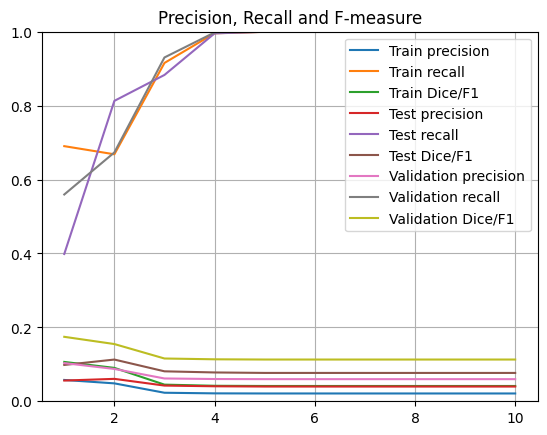

100%|██████████| 10/10 [1:34:50<00:00, 569.02s/it]


pr_c, rec_c, f_meas, pr_nc, rec_nc
[0.0598493395713434, 1.0, 0.11293933455777685, nan, 0.0]
{'train_loss': -94.18651580810547, 'train_accuracy': 2.1121084712115454, 'train_nochange_accuracy': 0.0, 'train_change_accuracy': 100.0, 'test_loss': -34.35863494873047, 'test_accuracy': 3.9877626330576303, 'test_nochange_accuracy': 0.0, 'test_change_accuracy': 100.0, 'validation_accuracy': 5.98493395713434, 'validation_nochange_accuracy': 0.0, 'validation_change_accuracy': 100.0}
SAVE OK


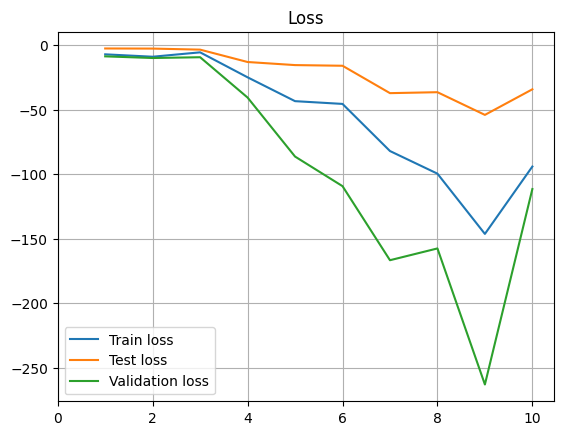

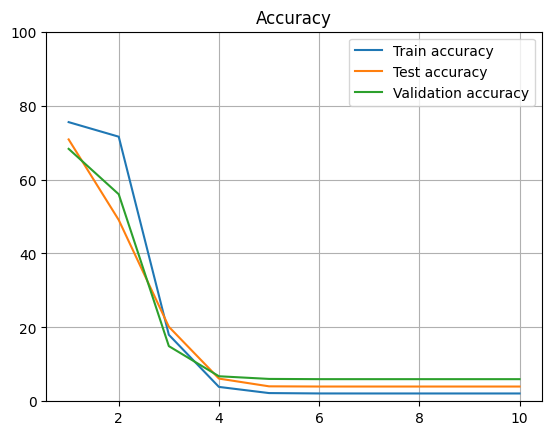

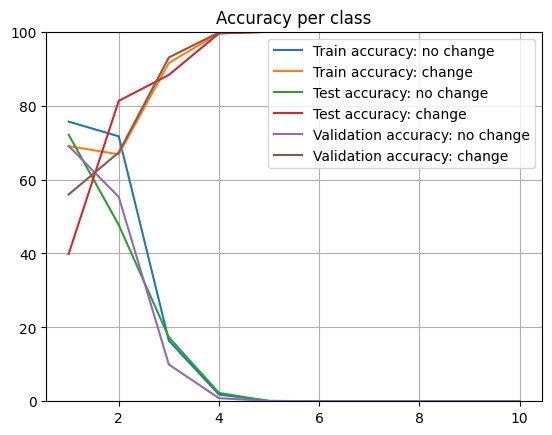

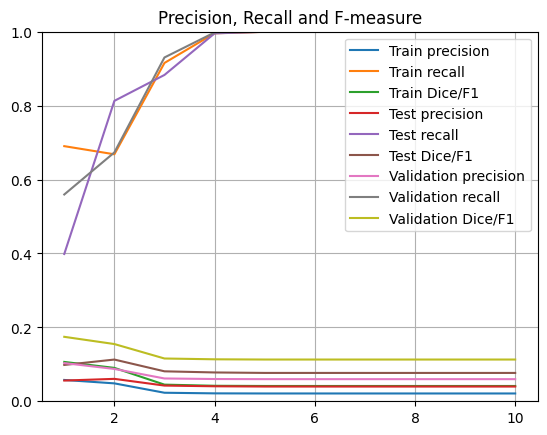

In [12]:
if LOAD_TRAINED:
    net.load_state_dict(torch.load('net_final.pth.tar'))
    print('LOAD OK')
else:
    out_dic = train()
    print(out_dic)

if not LOAD_TRAINED:
    torch.save(net.state_dict(), 'net_final.pth.tar')
    print('SAVE OK')

###Funzione save test

In [25]:
def save_test_results(dset):
    for name in tqdm(dset.names):
        with warnings.catch_warnings():
            I1, I2, cm = dset.get_img(name)
            I1 = Variable(torch.unsqueeze(I1, 0).float()).cuda()
            I2 = Variable(torch.unsqueeze(I2, 0).float()).cuda()

            input_batch = torch.cat((I1, I2), dim=1)
            out = net(input_batch)
            _, predicted = torch.max(out.data, 1)
            I = np.stack((255*cm,255*np.squeeze(predicted.cpu().numpy()),255*cm),2)
            io.imsave(f'{net_name}-{name}.png',I)

###Valutazione del test

In [26]:
save_test_results(train_dataset)
save_test_results(test_dataset)
save_test_results(validation_dataset)


L = 1024

def kappa(tp, tn, fp, fn):
    N = tp + tn + fp + fn
    p0 = (tp + tn) / N
    pe = ((tp+fp)*(tp+fn) + (tn+fp)*(tn+fn)) / (N * N)

    return (p0 - pe) / (1 - pe)

def test(dset):
    net.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0

    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for img_index in tqdm(dset.names):
        I1_full, I2_full, cm_full = dset.get_img(img_index)

        s = cm_full.shape

        for ii in range(ceil(s[0]/L)):
            for jj in range(ceil(s[1]/L)):
                xmin = L*ii
                xmax = min(L*(ii+1),s[1])
                ymin = L*jj
                ymax = min(L*(jj+1),s[1])
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                I1 = Variable(torch.unsqueeze(I1, 0).float()).cuda()
                I2 = Variable(torch.unsqueeze(I2, 0).float()).cuda()
                cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float()).cuda()

                input_batch = torch.cat((I1, I2), dim=1)
                output = net(input_batch)

                loss = criterion(output, cm.long())
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                _, predicted = torch.max(output.data, 1)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1

                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()

                tp += np.logical_and(pr, gt).sum()
                tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
                fp += np.logical_and(pr, np.logical_not(gt)).sum()
                fn += np.logical_and(np.logical_not(pr), gt).sum()

    net_loss = tot_loss/tot_count
    net_loss = float(net_loss.cpu().numpy())

    net_accuracy = 100 * (tp + tn)/tot_count

    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
        class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)

    pr_rec = [prec, rec, dice, prec_nc, rec_nc]

    k = kappa(tp, tn, fp, fn)

    return {'net_loss': net_loss,
            'net_accuracy': net_accuracy,
            'class_accuracy': class_accuracy,
            'precision': prec,
            'recall': rec,
            'dice': dice,
            'kappa': k}

print("Test dataset:")
results = test(test_dataset)
pprint(results)

print("Validation dataset:")
results = test(validation_dataset)
pprint(results)

  0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
<ipython-input-25-1e1851ccaca6>:12: UserWarning: FC-EF-aguasclaras.png is a low contrast image
  io.imsave(f'{net_name}-{name}.png',I)
  7%|▋         | 1/14 [00:00<00:02,  5.67it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/fun

{'class_accuracy': [0.0, 100.00000762939453],
 'dice': 0.07876987185953718,
 'kappa': 0.0,
 'net_accuracy': 4.099970675339017,
 'net_loss': -35.31104278564453,
 'precision': 0.04099970675339017,
 'recall': 1.0}


100%|██████████| 5/5 [00:50<00:00, 10.08s/it]

{'class_accuracy': [0.0, 100.0],
 'dice': 0.11853308326047604,
 'kappa': 0.0,
 'net_accuracy': 6.300035477949683,
 'net_loss': -114.5862808227539,
 'precision': 0.06300035477949684,
 'recall': 1.0}
